<a href="https://colab.research.google.com/github/monouns/SAI-board/blob/master/CNN_LRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Colab Notebooks/CNN_LRP

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/CNN_LRP


# 1. Data Pre-Processing

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data1 = pd.read_csv(f'./data/validation_1.csv')
data1.drop(columns=["Unnamed: 0"], inplace=True)
data2 = pd.read_csv(f'./data/validation_2.csv')
data2.drop(columns=["Unnamed: 0"], inplace=True)
data = pd.concat([data1, data2])
data.set_index('timestamp', inplace=True)
data

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C78,C79,C80,C81,C82,C83,C84,C85,C86,attack
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-07-10 00:00:01,-2.0395,0,11.78894,0.00058,16.32080,0.4010,12.903438,70,1,50,...,31.52100,0.716042,386.51172,356.64423,1,1034.712769,12.0,50,161,0
2021-07-10 00:00:02,-2.1750,0,11.78894,-0.00282,15.95459,0.4187,12.903438,70,1,50,...,31.51756,0.716042,411.33905,352.08698,1,1034.712769,12.0,50,155,0
2021-07-10 00:00:03,-2.5854,0,11.78131,-0.00398,14.79492,0.0691,12.903438,70,1,50,...,31.50269,0.716042,438.15259,347.63818,1,1034.712769,12.0,50,149,0
2021-07-10 00:00:04,-2.4722,0,11.78894,-0.00152,14.72626,0.3306,12.903438,70,1,50,...,31.47942,0.716042,465.95908,340.33203,1,1034.712769,12.0,50,148,0
2021-07-10 00:00:05,-2.2319,0,11.78131,0.00072,14.78729,0.2150,12.903438,70,1,50,...,31.47942,0.716042,452.05582,335.17798,1,1034.712769,12.0,50,148,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-10 23:59:56,-2.8150,0,12.26196,0.00130,15.53497,-0.0507,12.669310,70,1,50,...,31.79814,0.716042,1193.48230,347.58386,1,1018.394040,12.0,50,7,0
2021-07-10 23:59:57,-2.6272,0,12.26196,0.00109,15.53497,0.1829,12.669310,70,1,50,...,31.79738,0.716042,1179.76929,348.03607,1,1018.394040,12.0,50,7,0
2021-07-10 23:59:58,-2.3564,0,12.26196,-0.00101,15.53497,0.2907,12.669310,70,1,50,...,31.78784,0.716042,1152.66187,348.81366,1,1018.394040,12.0,50,7,0


In [5]:
df = data[['attack']]
df['filter'] = df['attack']==1
df_attack = df.loc[df['filter']==True]

attack_timeline = []
attack_start = df_attack.index[0]
flag = True

cnt = len(df.loc[:attack_start])
while True:
  if df.iloc[cnt]['filter']==False and flag==True:
    attack_end = df.index[cnt]
    attack_timeline.append([attack_start, attack_end])
    flag = False
  elif df.iloc[cnt]['filter']==True and flag==False:
    attack_start = df.index[cnt]
    flag = True
  cnt += 1
  if cnt == len(df):
    break
print(attack_timeline)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[['2021-07-10 05:41:22', '2021-07-10 05:44:33'], ['2021-07-10 07:19:12', '2021-07-10 07:20:07'], ['2021-07-10 11:25:13', '2021-07-10 11:27:20'], ['2021-07-10 15:39:12', '2021-07-10 15:40:07'], ['2021-07-10 16:42:17', '2021-07-10 16:47:14'], ['2021-07-10 19:21:16', '2021-07-10 19:22:48'], ['2021-07-10 22:35:20', '2021-07-10 22:36:28']]


In [6]:
for start, end in attack_timeline:
  print(len(df.loc[:end]))

20673
26407
41240
56407
60434
69768
81388


In [7]:
sc = StandardScaler()
train = data.iloc[:60000, :-1]
train_y = data.iloc[:60000, -1]
valid = data.iloc[60000:70000, :-1]
valid_y = data.iloc[60000:70000, -1]
test = data.iloc[70000:, :-1]
test_y = data.iloc[70000:, -1]

sc.fit(train.values)
train_sc = pd.DataFrame(sc.transform(train.values), columns=train.columns)
valid_sc = pd.DataFrame(sc.transform(valid.values), columns=valid.columns)
test_sc = pd.DataFrame(sc.transform(test.values), columns = test.columns)

# 2. Pytorch CNN model

In [8]:
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F

from sklearn.utils import class_weight
from tqdm.notebook import tqdm

SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [9]:
window = 1
batch_size = 256
num_workers = 4
pin_memory = True
device='cuda'
lr = 1e-4
num_epoch=5

In [10]:
class MyDataset(Dataset):
    def __init__(self, data, y, window):
        self.x = torch.Tensor(data)
        self.y = torch.Tensor(y)
        self.window = window
        self.shape = self.__getshape__()
        self.size = self.__getsize__()
        
    def __getitem__(self, index):
        x = self.x[index: index+self.window, :].T
        y = self.y[index+self.window]
        return x, y
    
    def __len__(self):
        return len(self.x)-self.window
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)
    
    def __getsize__(self):
        return (self.__len__())

In [11]:
train_dataset = MyDataset(data = train_sc.values,
                          y = train_y.values,
                         window = window,
                         )
valid_dataset = MyDataset(data = valid_sc.values,
                          y = valid_y.values,
                         window = window,)
test_dataset = MyDataset(data = test_sc.values,
                          y = test_y.values,
                         window = window,)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          drop_last=False,
                                          shuffle=True,
                                          num_workers=num_workers,
                                          pin_memory=pin_memory)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=batch_size,
                                          drop_last=False,
                                          shuffle=False,
                                          num_workers=num_workers,
                                          pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          drop_last=False,
                                          shuffle=False,
                                          num_workers=num_workers,
                                          pin_memory=pin_memory)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
class DNN(nn.Module):
    def __init__(self, in_features):
        super(DNN, self).__init__()
        self.hidden = 4
        
        self.fc1 = nn.Linear(in_features*window, self.hidden)      
        self.fc2 = nn.Linear(self.hidden, 1)
        
        self.relu = nn.Tanh()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = self.relu(self.dropout(self.fc1(out)))
        out = self.fc2(out)
        
        return out
    
model = DNN(in_features = len(train_sc.columns)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

weight1 = class_weight.compute_class_weight(class_weight = "balanced" , 
                     classes=np.unique(train_y.values), 
                     y = train_y.values)
weight1 = torch.as_tensor(np.unique(weight1)[1]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight = weight1)

In [13]:
train_loss_list = []  
valid_loss_list = []
valid_acc_list=[]
for epoch in range(num_epoch):
        model.train()
        total_step = len(train_loader)
        total, total_ce_loss, total_dtw_loss = 0, 0, 0
       
        for x,y in tqdm(train_loader, leave=False):
            x, y = x.cuda(), y.cuda()
            logits = model(x)

            ce_loss = criterion(logits.squeeze(), y.squeeze())
            optimizer.zero_grad()
            ce_loss.backward(retain_graph=True)
            optimizer.step()

            with torch.no_grad():
                total_ce_loss += ce_loss.item() * x.size(0)
                total += x.size(0)
            
        train_loss = total_ce_loss / total
        train_loss_list.append(train_loss)
       
        predictions = []
        answers = []
        with torch.no_grad():
            model.eval()
            correct, test_total = 0, 0
            total_step = len(valid_loader)
            total, total_ce_loss, total_dtw_loss = 0, 0, 0
            for x,y in tqdm(valid_loader, leave=False):
                x, y = x.cuda(), y.cuda()
                answers.extend(y.detach().cpu().numpy())
                
                logits = model(x)
                _, predicted = torch.max(nn.Sigmoid()(logits), 1)
                predictions.extend(predicted.detach().cpu().numpy())
                
                test_total += x.size(0)
                correct += (predicted == y.squeeze()).sum().item()
                
                ce_loss = criterion(logits.squeeze(), y.squeeze())
                total_ce_loss += ce_loss.item() * x.size(0)
                total += x.size(0)
            
            valid_loss_list.append(total_ce_loss/total)
            valid_acc_list.append(correct/test_total)
        print(valid_loss_list[-1])

  0%|          | 0/235 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/40 [00:00<?, ?it/s]

2.861230563343686


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

2.813133372791005


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

2.8021839782170908


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

2.8275115117929928


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

2.8811843679754574


In [14]:
predictions = []
answers = []
with torch.no_grad():
    model.eval()
    correct, test_total = 0, 0
    total_step = len(test_loader)
    total, total_ce_loss, total_dtw_loss = 0, 0, 0
    for x,y in tqdm(valid_loader, leave=False):
        x, y = x.cuda(), y.cuda()
        answers.extend(y.detach().cpu().numpy())
        
        logits = model(x)
        _, predicted = torch.max(nn.Sigmoid()(logits), 1)
        predictions.extend(predicted.detach().cpu().numpy())
        
        test_total += x.size(0)
        correct += (predicted == y.squeeze()).sum().item()
        
        ce_loss = criterion(logits.squeeze(), y.squeeze())
        total_ce_loss += ce_loss.item() * x.size(0)
        total += x.size(0)
print("Loss", total_ce_loss/total, "ACC", correct/test_total)

  0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss 2.8811843679754574 ACC 0.9610961096109611


# 3. Captum LRP

In [15]:
from captum.attr import LRP

In [16]:
lrp = LRP(model)

In [17]:
predictions = []
answers = []
relevance = []
with torch.no_grad():
    model.eval()
    correct, test_total = 0, 0
    total_step = len(test_loader)
    total, total_ce_loss, total_dtw_loss = 0, 0, 0
    for x,y in tqdm(valid_loader, leave=False):
        x, y = x.cuda(), y.cuda()
        answers.extend(y.detach().cpu().numpy())
        
        logits = model(x)
        _, predicted = torch.max(nn.Sigmoid()(logits), 1)
        predictions.extend(predicted.detach().cpu().numpy())
        
        test_total += x.size(0)
        correct += (predicted == y.squeeze()).sum().item()
        
        ce_loss = criterion(logits.squeeze(), y.squeeze())
        total_ce_loss += ce_loss.item() * x.size(0)
        total += x.size(0)

        input_relevance_values = lrp.attribute(x)
        relevance.append(input_relevance_values.detach().cpu().numpy())
    relevance = np.vstack(relevance).squeeze()

  0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


In [18]:
relevance.shape

(9999, 86)

In [20]:
rel_test = pd.DataFrame(np.abs(relevance).mean(axis=0), index=test_sc.columns, columns=['ABS_MEAN'])

In [21]:
rel_test = rel_test.sort_values(by='ABS_MEAN', ascending=False)
top_ranking = rel_test.index[:20]

In [30]:
def draw_heatmap_2d(rel):
    mean_train = np.abs(rel).mean(axis=0)
    print(mean_train.shape)
    
    maximum = mean_train.max()
    minimum  = mean_train.min()
    norm_train = (mean_train-minimum)/(maximum-minimum)
    print(norm_train.shape)
    
    fig, ax = plt.subplots(1,1, dpi=100)
    sns.heatmap(norm_train.reshape(-1,1), vmin=0, vmax=1, ax=ax, cbar=False, cmap='Blues')
    ax.set_xlabel('Time')
    ax.set_ylabel('Sensors')
    
    fig.suptitle('Absolute Relevances')

(86,)
(86,)


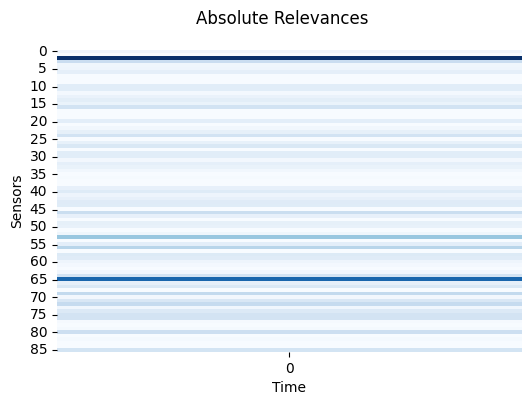

In [31]:
draw_heatmap_2d(relevance)

In [32]:
top_ranking

Index(['C03', 'C66', 'C54', 'C57', 'C70', 'C73', 'C04', 'C47', 'C81', 'C25',
       'C17', 'C65', 'C77', 'C76', 'C86', 'C72', 'C68', 'C28', 'C75', 'C59'],
      dtype='object')

In [33]:
rel_test = rel_test / rel_test.sum()
rel_test.reset_index(inplace=True)
rel_test.rename(columns={"index": "Sensors"}, inplace=True)
rel_test.to_csv('./data/ranking.csv',index=0)

In [34]:
rel_test

,Sensors,ABS_MEAN
0,C03,0.119028
1,C66,0.094645
2,C54,0.046290
3,C57,0.034967
4,C70,0.030734
...,...,...
81,C52,0.000000
82,C39,0.000000
83,C49,0.000000
84,C02,0.000000
